# [Lukas Vasquez Verdejo]

En esta tarea vas a experimentar con diferentes funciones de activación y su rol en el aprendizaje de redes neuronales. Lo primero que haremos es importar los paquetes importantes para nuestro notebook e inicializar el gpu. Asegúrate que tu notebook se ejecuta sobre un GPU. Si es así, al ejecutar la siguiente celda debería salirte el mensaje "cuda".

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import time
import numpy as np
import matplotlib.pyplot as plt
import random

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


A continuación hay un conjunto de funciones que puedes usar para hacer tus experimentos. Los detalles de cada función están como comentario antes del código de la función.

In [2]:
#Esta función permite inicializar todas las semillas de números pseudoaleatorios.
# Puedes usar esta función para resetear los generadores de números aleatorios
def iniciar_semillas():
  SEED = 1234

  random.seed(SEED)
  np.random.seed(SEED)
  torch.manual_seed(SEED)
  torch.cuda.manual_seed(SEED)
  torch.backends.cudnn.deterministic = True

#Función para computar el accuracy. Se asume que predicciones y etiquetas son tensores en el GPU
def calculate_accuracy(y_pred, y):
  top_pred = y_pred.argmax(1, keepdim=True)
  correct = top_pred.eq(y.view_as(top_pred)).sum()
  acc = correct.float()/y.shape[0]
  return acc

#Función para entrenar una época de un modelo. Recibe como parámetros
#     -model: una red neuronal
#     -iterator: un iterador de la data a usar para el entrenamiento (generalmente creado con un DataLoader)
#     -optimizer: el optimizador para el entrenamiento
#     -criterion: la función de loss
#     -device: dispositivo a usar para el entrenamiento
#
#Devuelve el loss promedio y el accuracy promedio de la época (promedio de todos los batches)
def train_one_epoch(model, iterator, optimizer, criterion, device):
  epoch_loss = 0
  epoch_acc = 0

  #We have to set the neural network in training mode. This is because during
  #training, we need gradients and complementary data to ease the computation  
  model.train()
  
  #Training loop
  for (x, y) in iterator:
    x = x.to(device) #Data
    y = y.long().to(device) #Labels
        
    optimizer.zero_grad() #Clean gradients
             
    y_pred = model(x) #Feed the network with data
        
    loss = criterion(y_pred, y) #Compute the loss
       
    acc = calculate_accuracy(y_pred, y) #Compute the accuracy
        
    loss.backward() #Compute gradients
        
    optimizer.step() #Apply update rules
        
    epoch_loss += loss.item()
    epoch_acc += acc.item()
        
  return epoch_loss / len(iterator), epoch_acc / len(iterator)

#Función que evalúa una red neuronal con un conjunto de datos de prueba. Recibe como parámetros
#     -model: una red neuronal
#     -iterator: un iterador de la data a usar para el entrenamiento (generalmente creado con un DataLoader)
#     -criterion: la función de loss
#     -device: dispositivo a usar para el entrenamiento
#Devuelve el loss promedio y el accuracy promedio de la época (promedio de todos los batches)
def evaluate(model, iterator, criterion, device):
  epoch_loss = 0
  epoch_acc = 0

  #We put the network in testing mode
  #In this mode, Pytorch doesn't use features only reserved for 
  #training (dropout for instance)    
  model.eval()
    
  with torch.no_grad(): #disable the autograd engine (save computation and memory)
        
    for (x, y) in iterator:
      x = x.to(device)
      y = y.long().to(device)

      y_pred= model(x)

      loss = criterion(y_pred, y)
      acc = calculate_accuracy(y_pred, y)

      epoch_loss += loss.item()
      epoch_acc += acc.item()

  return epoch_loss / len(iterator), epoch_acc / len(iterator)

#Calcula el tiempo transcurrido entre dos timestamps
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

#Esta función realiza el entrenamiento completo de una red. Recibe como parámetros:
#     -network: la red neuronal
#     -optimizer: el optimizador para entrenamiento
#     -train_loader: el dataloader de datos de entrenamiento
#     -tes_loader: el dataloader de datos de prueba
#     -name: nombre a usar para guardar en disco la red con el mejor accuracy

def train_complete(network, optimizer, train_loader, test_loader, name,verbose):
  #listas para retornar el accuracy  y loss 
  evol_train_loss=[] 
  evol_train_acc=[] 
  evol_test_loss=[] 
  evol_test_acc=[] 
  
  #Se envían la red y la función de loss al GPU
  network = network.to(device)
  criterion = nn.CrossEntropyLoss() #softmax 
  criterion = criterion.to(device)

  #Fijar el entrenamiento en 20 épocas siempre
  EPOCHS = 20

  best_valid_acc = float('-inf')

  for epoch in range(EPOCHS):
    
    start_time = time.time()

    #Train + validation cycles  
    train_loss, train_acc = train_one_epoch(network, train_loader, optimizer, criterion, device)
    evol_train_loss.append(train_loss)
    valid_loss, valid_acc = evaluate(network, test_loader, criterion, device)
    evol_test_loss.append(valid_loss)
    
    #Si encontramos un modelo con accuracy de validación mayor, lo guardamos
    if valid_acc > best_valid_acc:
     best_valid_acc = valid_acc
     torch.save(network.state_dict(), f'{name}.pt')
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    if verbose:
      print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
      print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
      print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

  
  #Cuando se termina el entrenamiento, cargamos el mejor modelo guardado y calculamos el accuracy de prueba
  network.load_state_dict(torch.load(f'{name}.pt'))
  test_loss , test_acc = evaluate(network, test_loader, criterion, device)
 

  print(f'Test Loss: {test_loss:.3f} | Mejor test acc: {test_acc*100:.2f}%')
  return dict(acc=test_acc*100,test_loss=evol_test_loss,train_loss=evol_train_loss)

Para nuestros experimentos usaremos el dataset FashionMNIST, que consta de imágenes en escala de grises de 28x28 píxeles que representan prendas de ropa clasificadas en 10 clases. Inicializamos los hiperparámetros y cargamos los conjuntos de datos de entrenamiento y prueba. También se crean los dataloaders correspondientes.

In [3]:
# Hyper-parameters 
input_size = 784
num_classes = 10
batch_size_train = 1000
batch_size_test = 1000
momentum = 0.9
log_interval = 100
learning_rate=0.01

# MNIST dataset 
train_dataset = torchvision.datasets.FashionMNIST(root='data', 
                    train=True, 
                    transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,),(0.5,))]),  
                    download=True)


test_dataset = torchvision.datasets.FashionMNIST(root='data', 
                                          train=False, 
                                          transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,),(0.5,))]))


# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size_train, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size_test, 
                                          shuffle=False)

class_names = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot']


  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



Inspeccionamos algunas muestras del conjunto de datos de prueba

Numero de batch: 0
torch.Size([1000, 1, 28, 28])
torch.Size([1000])


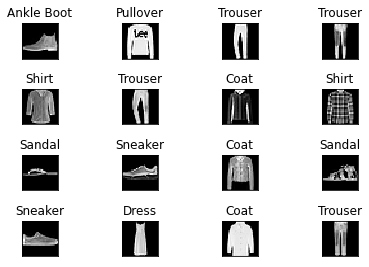

In [4]:
examples = enumerate(test_loader) #Crea un iterador sobre la lista de batches
batchId, (exampleData, exampleTargets) = next(examples) #Obtenemos el siguiente batch
print('Numero de batch: {}'.format(batchId))
print(exampleData.shape)
print(exampleTargets.shape)

import matplotlib.pyplot as plt

#Mostramos los primeros 6 elementos del batch con su etiqueta
plt.figure()
for i in range(16):
  plt.subplot(4, 4, i+1)
  plt.tight_layout()
  plt.imshow(exampleData[i][0], cmap='gray', interpolation='none')
  plt.title(class_names[exampleTargets[i]])
  plt.xticks([])
  plt.yticks([])

# Parte 1 - Creación de red neuronal
Crea una arquitectura de red neuronal (MLP - multilayer perceptron) que reciba datos de 784 dimensiones (recuerda que las imágenes del experimento son de 28x28 = 784 píxeles) y tenga 10 neuronas de salida. Para esta primera red usa la función sigmoide como función de activación en todas las capas ocultas y la función softmax en la capa de salida (recuerda que si usas nn.CrossEntropyLoss, no necesitas aplicar ninguna función adicional a la última capa de la red).

In [5]:
INPUT_DIM=784
OUTPUT_DIM=10
#Creamos la red neuronal
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class NetSigmoid(nn.Module):
  def __init__(self):
    super(NetSigmoid, self).__init__()
    # Define aquí las capas de tu red
    self.fc1 = nn.Linear(INPUT_DIM, 250)
    self.fc2 = nn.Linear(250, 100)
    self.fc3 = nn.Linear(100, 50)
    self.fc4 = nn.Linear(50, OUTPUT_DIM)

    
  def forward(self, x):
    #Implementa la función forward usando la función de activación sigmoide en las capas ocultas
    batch_size = x.shape[0]
    input = x.view(batch_size, -1)
    h_1 = torch.sigmoid(self.fc1(input))
    h_2 = torch.sigmoid(self.fc2(h_1))
    h_3 = torch.sigmoid(self.fc3(h_2))
    y_pred = self.fc4(h_3)

    return y_pred


Para ejecutar el entrenamiento de tu primer modelo, ejecuta la siguiente celda y debería reportarte el accuracy de prueba de este primer experimento. Cuánto obtienes de accuracy de test?

Epoch: 01 | Epoch Time: 0m 14s
	Train Loss: 1.226 | Train Acc: 50.94%
	 Val. Loss: 0.802 |  Val. Acc: 67.66%
Epoch: 02 | Epoch Time: 0m 9s
	Train Loss: 0.614 | Train Acc: 77.22%
	 Val. Loss: 0.536 |  Val. Acc: 81.35%
Epoch: 03 | Epoch Time: 0m 11s
	Train Loss: 0.454 | Train Acc: 84.31%
	 Val. Loss: 0.467 |  Val. Acc: 83.38%
Epoch: 04 | Epoch Time: 0m 9s
	Train Loss: 0.403 | Train Acc: 85.93%
	 Val. Loss: 0.423 |  Val. Acc: 85.08%
Epoch: 05 | Epoch Time: 0m 9s
	Train Loss: 0.368 | Train Acc: 87.07%
	 Val. Loss: 0.425 |  Val. Acc: 85.03%
Epoch: 06 | Epoch Time: 0m 9s
	Train Loss: 0.358 | Train Acc: 87.26%
	 Val. Loss: 0.427 |  Val. Acc: 84.59%
Epoch: 07 | Epoch Time: 0m 10s
	Train Loss: 0.348 | Train Acc: 87.47%
	 Val. Loss: 0.401 |  Val. Acc: 85.84%
Epoch: 08 | Epoch Time: 0m 10s
	Train Loss: 0.329 | Train Acc: 88.26%
	 Val. Loss: 0.397 |  Val. Acc: 85.93%
Epoch: 09 | Epoch Time: 0m 9s
	Train Loss: 0.306 | Train Acc: 89.15%
	 Val. Loss: 0.383 |  Val. Acc: 86.26%
Epoch: 10 | Epoch Time: 

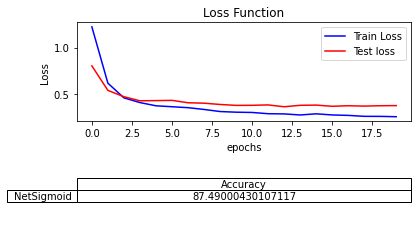

In [6]:
iniciar_semillas() # Se inicializan las semillas
network = NetSigmoid() # Creas la red
optimizer = optim.Adam(network.parameters(), lr=learning_rate) #Creas el optimizador
NetSigmoid_results=train_complete(network, optimizer, train_loader, test_loader, 'sigmoid',True) #Entrenas la red. IMPORTANTE: el número de épocas siempre debe ser el mismo (internamente son 20 épocas)

fig, (ax1,ax2)=plt.subplots(2,1)

ax1.set_title("Loss Function")
ax1.set
ax1.plot(NetSigmoid_results.get("train_loss"), color='b', label='Train Loss')
ax1.plot(NetSigmoid_results.get("test_loss"), color='r', label='Test loss')
ax1.set_xlabel("epochs")
ax1.set_ylabel("Loss")
ax1.legend()

fig.patch.set_visible(False)
ax2.axis('off')
ax2.table(cellText=[[NetSigmoid_results.get("acc")]], cellColours=None, cellLoc='center' , rowLabels=["NetSigmoid"], rowColours=None, rowLoc='left'
,colLabels=["Accuracy"], colColours=None, colLoc='center', loc='center', bbox=None, edges='closed'
)
plt.show() 

Se obtiene los siguientes resultados:

El objetivo de las funciones de activación es agregar cierto grado de no linearidad dentro de la red neuronal.La funcion sigmoide está dada por la siguiente expresión: <br>
<center>$sigmoid(x)=\frac{e^x}{1+e^x}$  </center> <br>

Para esta función de activación se  obtiene un accuracy de test de 87.5%.Esta función toma cualquier input (sin importar su módulo) y lo transforma en un valor entre 0 y 1,en otras palabras a partir de un gran cambio en el input causa un pequeño cambio en el output (su derivada se hace pequeña),por este comportamiento se dice  que sufre de "desvanecimiento" en el gradiente.Este punto es relevante pues en la medida que se aumente el número de capas en la red, el gradiente se hace tan pequeño que la red es difícil de entrenar.Veamos el siguiente ejemplo con una red de 7 capas:

Epoch: 01 | Epoch Time: 0m 10s
	Train Loss: 2.260 | Train Acc: 11.37%
	 Val. Loss: 1.958 |  Val. Acc: 19.97%
Epoch: 02 | Epoch Time: 0m 11s
	Train Loss: 1.718 | Train Acc: 25.19%
	 Val. Loss: 1.521 |  Val. Acc: 29.43%
Epoch: 03 | Epoch Time: 0m 10s
	Train Loss: 1.321 | Train Acc: 41.67%
	 Val. Loss: 1.052 |  Val. Acc: 56.44%
Epoch: 04 | Epoch Time: 0m 10s
	Train Loss: 0.897 | Train Acc: 64.07%
	 Val. Loss: 0.864 |  Val. Acc: 66.60%
Epoch: 05 | Epoch Time: 0m 9s
	Train Loss: 0.769 | Train Acc: 69.63%
	 Val. Loss: 0.759 |  Val. Acc: 70.10%
Epoch: 06 | Epoch Time: 0m 9s
	Train Loss: 0.726 | Train Acc: 70.96%
	 Val. Loss: 0.733 |  Val. Acc: 71.38%
Epoch: 07 | Epoch Time: 0m 9s
	Train Loss: 0.684 | Train Acc: 72.61%
	 Val. Loss: 0.703 |  Val. Acc: 72.63%
Epoch: 08 | Epoch Time: 0m 10s
	Train Loss: 0.649 | Train Acc: 74.38%
	 Val. Loss: 0.655 |  Val. Acc: 76.09%
Epoch: 09 | Epoch Time: 0m 10s
	Train Loss: 0.600 | Train Acc: 78.06%
	 Val. Loss: 0.603 |  Val. Acc: 77.94%
Epoch: 10 | Epoch Time

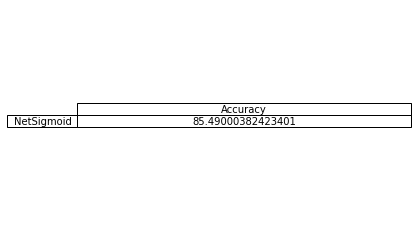

In [7]:
INPUT_DIM=784
OUTPUT_DIM=10
#Creamos la red neuronal
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class NetSigmoidmulti(nn.Module):
  def __init__(self):
    super(NetSigmoidmulti, self).__init__()
    # Define aquí las capas de tu red
    self.fc1 = nn.Linear(INPUT_DIM, 250)
    self.fc2 = nn.Linear(250, 200)
    self.fc3 = nn.Linear(200, 150)
    self.fc4 = nn.Linear(150, 100)
    self.fc5 = nn.Linear(100, 80)
    self.fc6 = nn.Linear(80, 50)
    self.fc7 = nn.Linear(50, OUTPUT_DIM)

    
  def forward(self, x):
    #Implementa la función forward usando la función de activación sigmoide en las capas ocultas
    batch_size = x.shape[0]
    input = x.view(batch_size, -1)
    h_1 = torch.sigmoid(self.fc1(input))
    h_2 = torch.sigmoid(self.fc2(h_1))
    h_3 = torch.sigmoid(self.fc3(h_2))
    h_4 = torch.sigmoid(self.fc4(h_3))
    h_5 = torch.sigmoid(self.fc5(h_4))
    h_6 = torch.sigmoid(self.fc6(h_5))
    y_pred = self.fc7(h_6)

    return y_pred


iniciar_semillas() # Se inicializan las semillas
network = NetSigmoidmulti() # Creas la red
optimizer = optim.Adam(network.parameters(), lr=learning_rate) #Creas el optimizador
NetSigmoidmulti_results=train_complete(network, optimizer, train_loader, test_loader, 'sigmoid',True) #Entrenas la red. IMPORTANTE: el número de épocas siempre debe ser el mismo (internamente son 20 épocas)

fig, ax2=plt.subplots()
fig.patch.set_visible(False)
ax2.axis('off')
ax2.table(cellText=[[NetSigmoidmulti_results.get("acc")]], cellColours=None, cellLoc='center' , rowLabels=["NetSigmoid"], rowColours=None, rowLoc='left'
,colLabels=["Accuracy"], colColours=None, colLoc='center', loc='center', bbox=None, edges='closed'
)
plt.show() 

Se obtiene un accuracy del 85%, esto posiblemente debido al "desvanecimiento" del gradiente.

# Parte 2
En esta parte vas a comparar el accuracy de test de la primera red que creaste (con función de activación sigmoide) y los accuracys obtenidos usando otras funciones de activación. Para lograr esto debes hacer lo siguiente:



*   Implementa exactamente la misma arquitectura que tu primera red, pero ahora vas a usar las siguientes funciones de activación: Leaky Relu, Mish, Elu y Silu. Implementa una clase por cada función de activación, en donde la red neuronal use la misma función de activación en las capas ocultas. Asegúrate que la arquitectura es la misma y que lo único que cambia entre las distintas redes es la función de activación de las capas ocultas.
*   Entrena cada red usando la función "train_complete" usando el mismo optimizador siempre. 
*   Registra los mejores accuracys de test de cada red neuronal.
*   Discute los resultados ontenidos. Puedes tratar de responder a estas preguntas:
    * Qué función de activación dio el mejor accuracy de test?
    * Porqué crees que, ante las mismas condiciones, hay funciones de activación que funcionan mejor que otras?
    * Averigua cómo funcionan cada una de las funciones de activación usadas en la tarea. Es posible hacer algún razonamiento sobre el comportamiento de cada función y que eso permita explicar los resultados de tu tarea?

Leaky Relu 

In [8]:
class NetLRelu(nn.Module):
  def __init__(self):
    super(NetLRelu, self).__init__()
    # Define aquí las capas de tu red
    self.fc1 = nn.Linear(INPUT_DIM, 250)
    self.fc2 = nn.Linear(250, 100)
    self.fc3 = nn.Linear(100, 50)
    self.fc4 = nn.Linear(50, OUTPUT_DIM)

    
  def forward(self, x):
    #Implementa la función forward usando la función de activación sigmoide en las capas ocultas
    batch_size = x.shape[0]
    input = x.view(batch_size, -1)
    h_1 = F.leaky_relu(self.fc1(input))
    h_2 = F.leaky_relu(self.fc2(h_1))
    h_3 = F.leaky_relu(self.fc3(h_2))
    y_pred = self.fc4(h_3)

    return y_pred


In [ ]:
iniciar_semillas() # Se inicializan las semillas
network = NetLRelu() # Creas la red
optimizer = optim.Adam(network.parameters(), lr=learning_rate) #Creas el optimizador
NetRelu_results=train_complete(network, optimizer, train_loader, test_loader, 'leaky relu',True) #Entrenas la red. IMPORTANTE: el número de épocas siempre debe ser el mismo (internamente son 20 épocas)

fig, (ax1,ax2)=plt.subplots(2,1)

ax1.set_title("Loss Function")
ax1.set
ax1.plot(NetRelu_results.get("train_loss"), color='b', label='Train Loss')
ax1.plot(NetRelu_results.get("test_loss"), color='r', label='Test loss')
ax1.set_xlabel("epochs")
ax1.set_ylabel("Loss")
ax1.legend()

fig.patch.set_visible(False)
ax2.axis('off')
ax2.table(cellText=[[NetRelu_results.get("acc")]], cellColours=None, cellLoc='center' , rowLabels=["NetSigmoid"], rowColours=None, rowLoc='left'
,colLabels=["Accuracy"], colColours=None, colLoc='center', loc='center', bbox=None, edges='closed'
)
plt.show()

Epoch: 01 | Epoch Time: 0m 9s
	Train Loss: 0.747 | Train Acc: 71.89%
	 Val. Loss: 0.471 |  Val. Acc: 82.69%
Epoch: 02 | Epoch Time: 0m 9s
	Train Loss: 0.403 | Train Acc: 85.24%
	 Val. Loss: 0.402 |  Val. Acc: 85.48%


Mish

In [ ]:
class NetMish(nn.Module):
  def __init__(self):
    super(NetMish, self).__init__()
    # Define aquí las capas de tu red
    self.fc1 = nn.Linear(INPUT_DIM, 250)
    self.fc2 = nn.Linear(250, 100)
    self.fc3 = nn.Linear(100, 50)
    self.fc4 = nn.Linear(50, OUTPUT_DIM)

    
  def forward(self, x):
    #Implementa la función forward usando la función de activación sigmoide en las capas ocultas
    batch_size = x.shape[0]
    input = x.view(batch_size, -1)
    h_1 = F.mish(self.fc1(input))
    h_2 = F.mish(self.fc2(h_1))
    h_3 = F.mish(self.fc3(h_2))
    y_pred = self.fc4(h_3)

    return y_pred


In [ ]:
iniciar_semillas() # Se inicializan las semillas
network = NetMish() # Creas la red
optimizer = optim.Adam(network.parameters(), lr=learning_rate) #Creas el optimizador
NetMish_results=train_complete(network, optimizer, train_loader, test_loader, 'Mish',True) #Entrenas la red. IMPORTANTE: el número de épocas siempre debe ser el mismo (internamente son 20 épocas)

fig, (ax1,ax2)=plt.subplots(2,1)
ax1.set_title("Loss Function")
ax1.set
ax1.plot(NetMish_results.get("train_loss"), color='b', label='Train Loss')
ax1.plot(NetMish_results.get("test_loss"), color='r', label='Test loss')
ax1.set_xlabel("epochs")
ax1.set_ylabel("Loss")
ax1.legend()

fig.patch.set_visible(False)
ax2.axis('off')
ax2.table(cellText=[[NetMish_results.get("acc")]], cellColours=None, cellLoc='center' , rowLabels=["NetSigmoid"], rowColours=None, rowLoc='left'
,colLabels=["Accuracy"], colColours=None, colLoc='center', loc='center', bbox=None, edges='closed'
)
plt.show()

Elu

In [ ]:
class NetElu(nn.Module):
  def __init__(self):
    super(NetElu, self).__init__()
    # Define aquí las capas de tu red
    self.fc1 = nn.Linear(INPUT_DIM, 250)
    self.fc2 = nn.Linear(250, 100)
    self.fc3 = nn.Linear(100, 50)
    self.fc4 = nn.Linear(50, OUTPUT_DIM)

    
  def forward(self, x):
    #Implementa la función forward usando la función de activación sigmoide en las capas ocultas
    batch_size = x.shape[0]
    input = x.view(batch_size, -1)
    h_1 = F.elu(self.fc1(input))
    h_2 = F.elu(self.fc2(h_1))
    h_3 = F.elu(self.fc3(h_2))
    y_pred = self.fc4(h_3)

    return y_pred

In [ ]:
iniciar_semillas() # Se inicializan las semillas
network = NetElu() # Creas la red
optimizer = optim.Adam(network.parameters(), lr=learning_rate) #Creas el optimizador
NetElu_results=train_complete(network, optimizer, train_loader, test_loader, 'Elu',True) #Entrenas la red. IMPORTANTE: el número de épocas siempre debe ser el mismo (internamente son 20 épocas)
fig, (ax1,ax2)=plt.subplots(2,1)

ax1.set_title("Loss Function")
ax1.set
ax1.plot(NetElu_results.get("train_loss"), color='b', label='Train Loss')
ax1.plot(NetElu_results.get("test_loss"), color='r', label='Test loss')
ax1.set_xlabel("epochs")
ax1.set_ylabel("Loss")
ax1.legend()

fig.patch.set_visible(False)
ax2.axis('off')
ax2.table(cellText=[[NetElu_results.get("acc")]], cellColours=None, cellLoc='center' , rowLabels=["NetSigmoid"], rowColours=None, rowLoc='left'
,colLabels=["Accuracy"], colColours=None, colLoc='center', loc='center', bbox=None, edges='closed'
)
plt.show()

Silu


In [ ]:
class NetSilu(nn.Module):
  def __init__(self):
    super(NetSilu, self).__init__()
    # Define aquí las capas de tu red
    self.fc1 = nn.Linear(INPUT_DIM, 250)
    self.fc2 = nn.Linear(250, 100)
    self.fc3 = nn.Linear(100, 50)
    self.fc4 = nn.Linear(50, OUTPUT_DIM)

    
  def forward(self, x):
    #Implementa la función forward usando la función de activación sigmoide en las capas ocultas
    batch_size = x.shape[0]
    input = x.view(batch_size, -1)
    h_1 = F.silu(self.fc1(input))
    h_2 = F.silu(self.fc2(h_1))
    h_3 = F.silu(self.fc3(h_2))
    y_pred = self.fc4(h_3)

    return y_pred

In [ ]:
iniciar_semillas() # Se inicializan las semillas
network = NetSilu() # Creas la red
optimizer = optim.Adam(network.parameters(), lr=learning_rate) #Creas el optimizador
NetSilu_results=train_complete(network, optimizer, train_loader, test_loader, 'Silu',True) #Entrenas la red. IMPORTANTE: el número de épocas siempre debe ser el mismo (internamente son 20 épocas)

fig, (ax1,ax2)=plt.subplots(2,1)

ax1.set_title("Loss Function")
ax1.set
ax1.plot(NetSilu_results.get("train_loss"), color='b', label='Train Loss')
ax1.plot(NetSilu_results.get("test_loss"), color='r', label='Test loss')
ax1.set_xlabel("epochs")
ax1.set_ylabel("Loss")
ax1.legend()

fig.patch.set_visible(False)
ax2.axis('off')
ax2.table(cellText=[[NetSilu_results.get("acc")]], cellColours=None, cellLoc='center' , rowLabels=["NetSigmoid"], rowColours=None, rowLoc='left'
,colLabels=["Accuracy"], colColours=None, colLoc='center', loc='center', bbox=None, edges='closed'
)
plt.show()

In [ ]:
fig, ax1=plt.subplots()

fig.patch.set_visible(False)
ax1.axis('off')
ax1.table(cellText=[[NetSigmoid_results.get("acc")],[NetRelu_results.get("acc")],[NetMish_results.get("acc")],[NetElu_results.get("acc")]], cellColours=None, cellLoc='center' , rowLabels=["Sigmoid","Leaky Relu","Mish","Elu",], rowColours=None, rowLoc='left'
,colLabels=["Accuracy"], colColours=None, colLoc='center', loc='center', bbox=None, edges='closed'
)
plt.show() 

La función que dió mejores resultados en terminos de accuracy es Leaky Relu con un 88.7% de accuracy.Si bien se obtuvieron resultados similares, estas funciones poseen ciertas diferencias:<br>
<ul>
<li>Leaky Relu es una versión modificada de Relu,está dada por la siguiente expresión:<br>

<center>$
\text {L_Relu(x)}
= 
\begin{cases}
x \text{ if }  x \geq  0\\
\alpha x \space {otherwise}
\end{cases}
$</center>
Una de las ventajas de esta funcion con respecto a Relu, es que  al poseer pendiente para los valores menores a 0, previene la perdida de neuronas (en Relu se pueden perder neuronas,es decir que estas retornen siempre 0, sin contribuir al proceso de entrenamiento).<br>

<br><li>ELU es una combinación de funciones conocidas,está dada por la siguiente expresión:<br>

<center>$
\text {ELU(x)}
= 
\begin{cases}
x \text{ if }  x \geq  0\\
\alpha(e^x-1) \space   \text{otherwise}
\end{cases}
$</center>


<li>Mish es una combinacipon de fun,está dada por la siguiente expresión:<br>

<center>$
\text {Mish(x)}
= x* \text{tanh}(\text{softplus}(x))$ </center>$
\text{donde} \space \text{tanh(x)}=(e^x-e^{-x}), \space \text{softplus(x)}=ln(1+e^x)
$

</ul>


<br>
Es posible notar una mejoría entre las funciones de la parte 2 con respecto a la función sigmoide esto ya que las funciones de la parte 2 previenen  el desvanecimiento de gradiente.<br>

Una de las posibles explicaciones del porque Leaky Relu es que esta al tener una derivada constante, su cómputo es menos costoso lo cual permite que la red que utilice esta función de acrivación aprenda más rápido, 

